In [1]:
import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
jet = mcm.get_cmap('jet')
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
%matplotlib inline 

filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Fe_Fep_02.nc"
#filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Na_Nap_02.nc"
#filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Mg_Mgp_02.nc"

filename2="Nc_Files/Jianfei_WACCMX_files/waccmx_T_Z3_e_02.nc"
filename3="Nc_Files/Jianfei_WACCMX_files/waccmx_winds_02.nc"

M = filename[-9:]
Metal=M[0:2]
#print(Metal)

ds = xr.open_dataset(filename)
ds2 = xr.open_dataset(filename2)
ds3 = xr.open_dataset(filename3)

#ds3

In [2]:
#ds1 variables

dst = ds.transpose("lev", ...)
Mt = dst.variables[str(Metal)]
Mpt = dst.variables[str(Metal)+'p']

In [3]:
#ds2 variables

ds2t = ds2.transpose("lev", ...)
temp = ds2t.variables['T']
elect = ds2t.variables['e']

geopH = ds2t.variables['Z3'] / 1000 #m-> km
Zavg = geopH.mean(('time','lat', 'lon'))

In [4]:
#ds3 variables
ds3t = ds3.transpose("lev", ...)

lon = ds3t.variables['lon'] #(144)
lat = ds3t.variables['lat'] #(96)
lev = ds3t.variables['lev'] #(126)
ilev = dst.variables['ilev'] #(127)

p0 = ds3t.variables['P0']
ps = ds3t.variables['PS'] #(672, 96, 144)
hyai = ds3t.variables['hyai'] #(127)
hybi = ds3t.variables['hybi'] #(127)


U = ds3t.variables['U'] #(126, 672, 96, 144) #U component is positive for a west to east flow (eastward wind) 
V = ds3t.variables['V'] #(126, 672, 96, 144) #V component is positive for south to north flow (northward wind)
omega = ds3t.variables['OMEGA']


In [5]:
timee = ds3t.variables['time'] #(672)
times = xr.cftime_range(start="0001-02-01", periods=672, freq="1H", calendar="noleap")
times2 = ds3t["time"].dt.strftime("%Y%m%d %H:%M")
times3 = ds3t["time"].dt.strftime("%Y%m%d")


In [6]:


#-----------------------------------------------------------------------------------------------------
# Slice arrays (lev, altitude) between chosen range
lev_sl_idx_min = 42
lev_sl_idx_max = 66
lev_sl = lev[lev_sl_idx_min:lev_sl_idx_max+1]

lev_sl_ind_min = lev[lev_sl_idx_min] 
lev_sl_ind_max = lev[lev_sl_idx_max] 
lev_sl_str = str("%.1e" % lev_sl_ind_min) + ' hPa : ' + str("%.1e" % lev_sl_ind_max) + ' hPa'
print('Plot lev = ' + lev_sl_str)


Zavg_sl = Zavg[lev_sl_idx_min:lev_sl_idx_max+1]

Zavg_sl_min = Zavg[lev_sl_idx_min] 
Zavg_sl_max = Zavg[lev_sl_idx_max]
Zavg_sl_str = str("%.0f" % Zavg_sl_min) + ' km : ' + str("%.0f" % Zavg_sl_max) + ' km'
print('Approx Z = ' + Zavg_sl_str)


geopH_sl = geopH[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]
#-----------------------------------------------------------------------------------------------------
# Slice by chosen alt range and time range (first 2 weeks of data)

U_wind = U[lev_sl_idx_min:lev_sl_idx_max+1,0:336,:,:] #(25, 336, 96, 144)
V_wind = U[lev_sl_idx_min:lev_sl_idx_max+1,0:336,:,:] #(25, 336, 96, 144)
#-----------------------------------------------------------------------------------------------------
ps_sl = ps[0:336,:,:] #(336, 96, 144)
hyai_sl = hyai[lev_sl_idx_min:lev_sl_idx_max+2] #(26)
hybi_sl = hybi[lev_sl_idx_min:lev_sl_idx_max+2] #(26)
#-----------------------------------------------------------------------------------------------------

Plot lev = 1.5e-05 hPa : 6.0e-03 hPa
Approx Z = 128 km : 81 km


In [7]:
timear = np.arange(0,336)
levar = np.arange(0,25)
ilevar = np.arange(0,26)
levarsl = np.arange(0,24)
latar = np.arange(0,96)
lonar = np.arange(0,144)

In [8]:
# Create array with time info for each day 
day = np.arange(0,24)
os =  day * 15 / 2.5 # Create an array with offset needed for each UT time step (24h period) - Offset by 15 degrees lon, lon axis is in 2.5 degree intervals

offset = np.empty(24, dtype=int) #Create offset array so it has same dims as day variable

for d in day:
    offset[d] =  ( int(os[d]) ) #convert floats to ints to get integer number of indices to offset by
print(offset)

# Stack multiple offset arrays to give offsets for consecutive days in the 2 week dataset 
offset2 = np.stack((offset, offset, offset, offset, offset, offset, offset), axis=0)
offset2 = np.reshape(offset2, (24*7))
offset3 = np.stack((offset2, offset2), axis=0)
offset3 = np.reshape(offset3, (168*2))

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138]


In [9]:
#Create _sh array so it has same dims etc as dens variable
U_wind_sh = np.ndarray(U_wind.shape, dtype = float) 
V_wind_sh = np.ndarray(V_wind.shape, dtype = float) 


#Iterate over timear, offsetting at each time by 15 degrees lon
for it in timear:
    U_wind_sh[:,it,:,:] = np.roll(U_wind[:,it,:,:], offset3[it] , axis=2)
    V_wind_sh[:,it,:,:] = np.roll(V_wind[:,it,:,:], offset3[it] , axis=2)

In [10]:
U2V2 = np.ndarray(U_wind.shape, dtype = float)
#U2V2.shape #(25, 336, 96, 144)

for it in timear:
    for ilon in lonar:
        for ilat in latar:
            for ilevsl in levarsl:
                U2V2[ilevsl,it, ilat,ilon] = math.sqrt( (U_wind_sh[ilevsl,it, ilat,ilon]**2) + (V_wind_sh[ilevsl,it, ilat,ilon]**2) )


In [11]:
#------------------------ Plot 1 setup: SpEs_plot-----------------------------

lev_sl_plot_idx = 15   #15 #~94km        #10 #~101km      #23=82km low lim?
lev_sl_plot = lev_sl[lev_sl_plot_idx]
lev_sl_plot_str = str("%.1e" % lev_sl_plot) + ' hPa'
print('Plot lev = ' + lev_sl_plot_str)


Zavg_slplot = Zavg_sl[lev_sl_plot_idx]
Zavg_sl_plot_str = str("%.0f" % Zavg_slplot) + ' km'
print('Approx Z = ' + Zavg_sl_plot_str)

Plot lev = 6.3e-04 hPa
Approx Z = 94 km


In [34]:
press = np.ndarray(2, dtype = float) 
alt = np.ndarray((2,336,96,144), dtype = float) 


hyai_slsl = hyai_sl[lev_sl_plot_idx:lev_sl_plot_idx+2]
hybi_slsl = hybi_sl[lev_sl_plot_idx:lev_sl_plot_idx+2]


start_time = time.process_time()

levarloop = np.ndarray(2,dtype=int)
levarloop[0] = 0
levarloop[1] = 1

for it in timear:
    for ilon in lonar:
        for ilat in latar:
            for ileev in levarloop:
                press = hyai_sl[ileev] * p0 + hybi_sl[ileev] * ps_sl[it,ilat,ilon] #hPa
                alt[ileev,it,ilat,ilon] = -7.* math.log( press / p0 )  #m
                

end_time = time.process_time()   

print(end_time - start_time) #66.09 s

3811.2492124279997


In [24]:
dz = np.ndarray((336, 96, 144), dtype = float) 
dU = np.ndarray((336, 96, 144), dtype = float)  
dUdz = np.ndarray((336, 96, 144), dtype = float)

dU2V2 = np.ndarray((336, 96, 144), dtype = float)
dU2V2dz = np.ndarray((336, 96, 144), dtype = float)

start_time = time.process_time()

for it in timear:
    for ilat in latar:
        for ilon in lonar:
            dz[it,ilat,ilon] = alt[0,it,ilat,ilon]-alt[1,it,ilat,ilon] #m
            dU[it,ilat,ilon] = U_wind_sh[lev_sl_plot_idx,it,ilat,ilon] - U_wind_sh[lev_sl_plot_idx+1,it,ilat,ilon] #ms-1
            dUdz[it,ilat,ilon] = dU[it,ilat,ilon] / dz[it,ilat,ilon] #s-1
            dU2V2[it,ilat,ilon] = U2V2[lev_sl_plot_idx,it,ilat,ilon] - U2V2[lev_sl_plot_idx+1,it,ilat,ilon] #ms-1
            dUdz[it,ilat,ilon] = dU2V2[it,ilat,ilon] / dz[it,ilat,ilon] #s-1


NameError: name 'alt' is not defined

In [25]:
#------------------------ Plot2 setup: SpEs_plot-----------------------------

lat_plot_idx = 21   #15 #~94km      #23=82km low lim?
lat_plot = lat[lat_plot_idx]
lat_plot_str = str("%.1f" % lat_plot) 
print('Plot lat = ' + lat_plot_str)

lev_sl_plot_min = lev_sl[0]
lev_sl_plot_max = lev_sl[-1]
lev_sl_plot_min_str = str("%.1e" % lev_sl_plot_min) + ' hPa'
lev_sl_plot_max_str = str("%.1e" % lev_sl_plot_max) + ' hPa'
print('Lev = ' + lev_sl_plot_max_str + ' : ' + lev_sl_plot_min_str)

Zavg_sl_plot_min = Zavg_sl[0]
Zavg_sl_plot_max = Zavg_sl[-1]
Zavg_sl_plot_min_str = str("%.0f" % Zavg_sl_plot_min) + ' km'
Zavg_sl_plot_max_str = str("%.0f" % Zavg_sl_plot_max) + ' km'
print('Approx Z = ' + Zavg_sl_plot_max_str + ' : ' + Zavg_sl_plot_min_str)


timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 

timeconv_plot_ticks = np.arange(0,25, dtype=float)

Plot lat = -50.2
Lev = 6.0e-03 hPa : 1.5e-05 hPa
Approx Z = 81 km : 128 km


/tmp/ipykernel_3571921/3333787807.py:58: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,


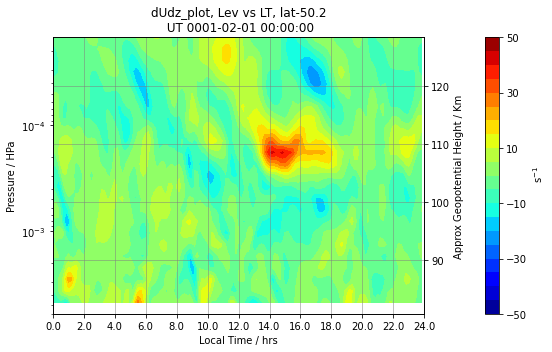

In [28]:
#----------------------------------------------------------------------------------------------------------
#-------------------------------------------  dUdz_plot  no arrows ---------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot_idx_start = 0  
time_plot_idx_end = 12

time_plot_ar = np.arange(time_plot_idx_start,time_plot_idx_end)

for itime in time_plot_ar:
    time_plot_idx = time_plot_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------
    time_plot = timee[time_plot_idx]
    times_plot = times[time_plot_idx]
    times_plot_str = str(times_plot)
    #print('Plot time = ' + times_plot1_str)   

    #---------------Set up plot variables----------------------------
    dUdz_plot = dUdz[:,time_plot_idx,:]

    #------------------------ SpEs_pd_plot -----------------------------

    ticks = np.linspace(-50, 50, 21)

    fig, ax = plt.subplots(figsize=(8, 5))
    C = ax.contourf(timeconv_plot, lev_sl[0:-1], dUdz_plot, 
                     levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.set_yscale('log')
    ax.set_ylabel('Pressure / HPa')
    ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    ax2 = ax.twinx()
    ax2.set_ylabel('Approx Geopotential Height / Km')
    ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)


    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 
    
    ax.set_title('dUdz_plot, Lev vs LT, lat' + lat_plot_str + '\n UT ' + times_plot_str )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
    
    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' s$^{-1}$')

    figname='dUdz_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_plot_str + '.png'
    plt.tight_layout()
    
    #plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/' + 'Winds/'+str(figname)) #



/tmp/ipykernel_3571921/609711346.py:62: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_3571921/609711346.py:62: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_3571921/609711346.py:62: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To sile

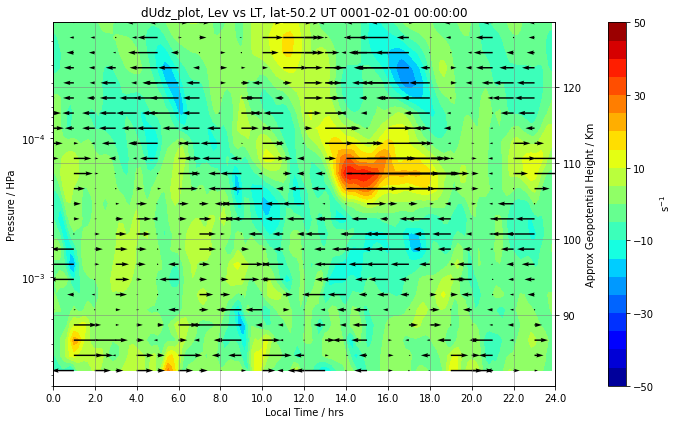

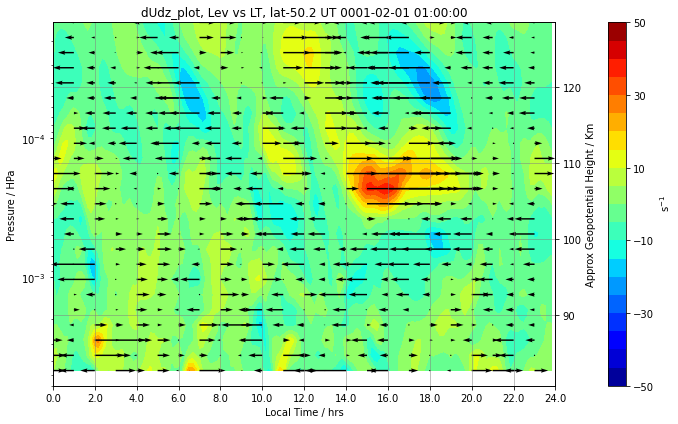

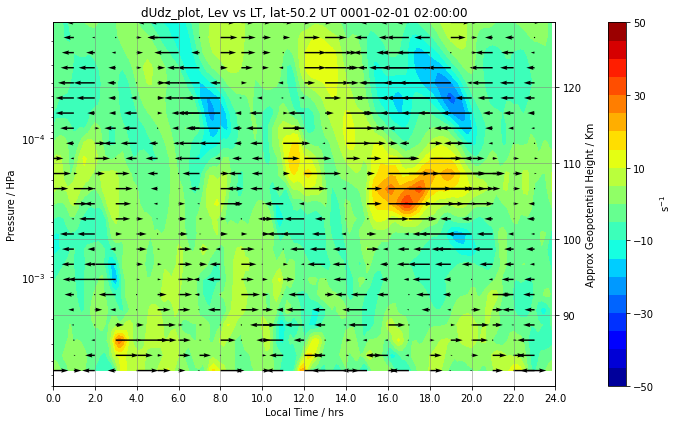

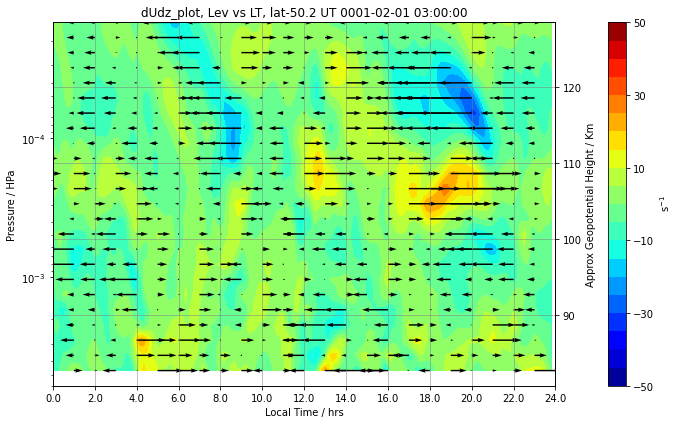

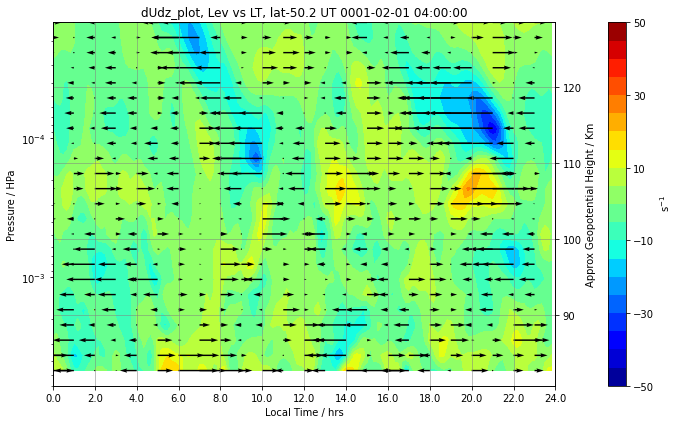

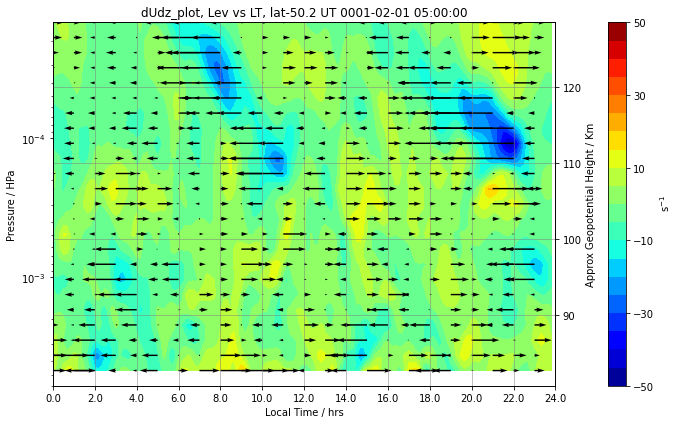

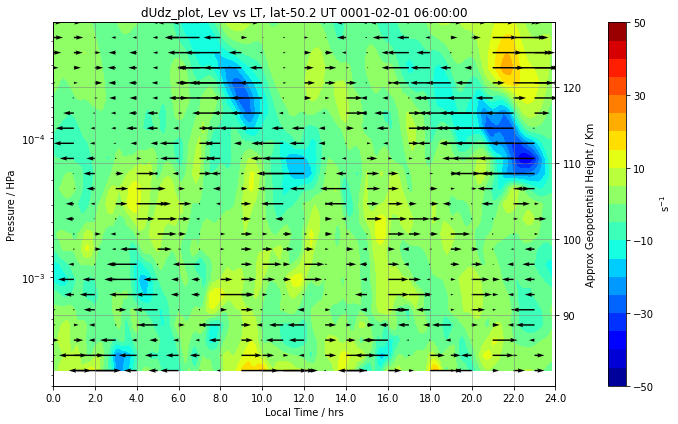

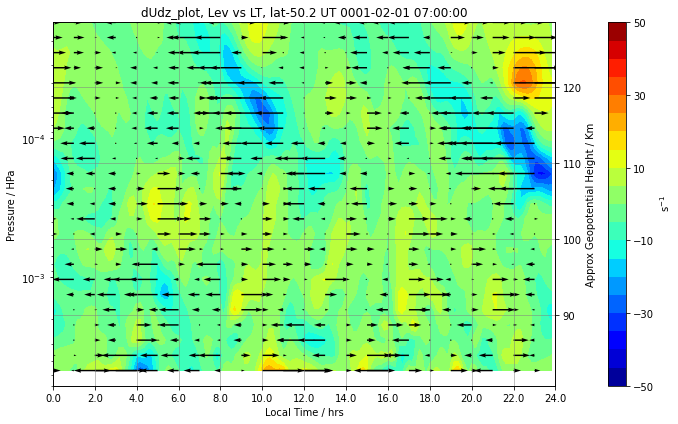

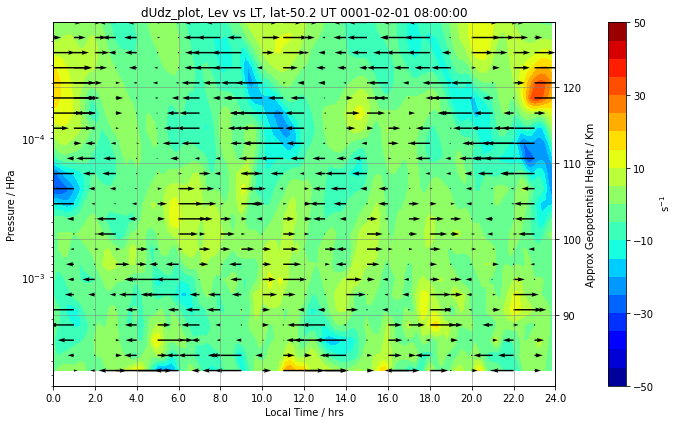

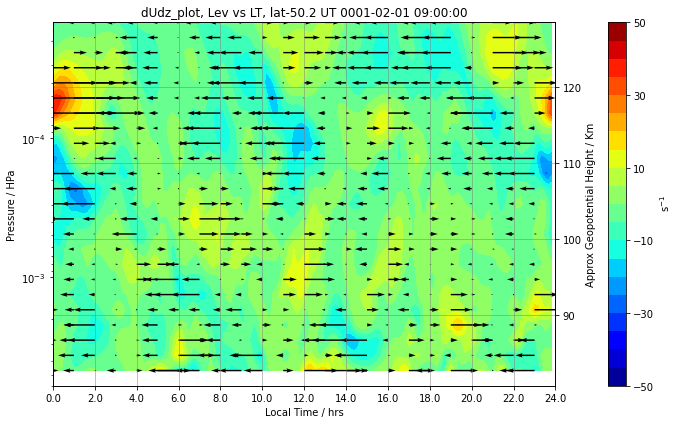

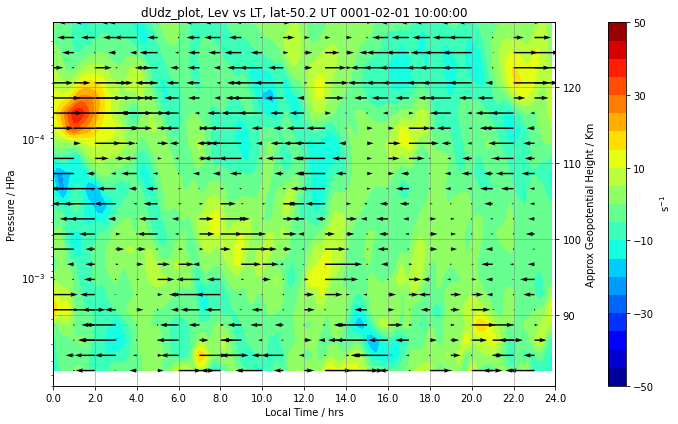

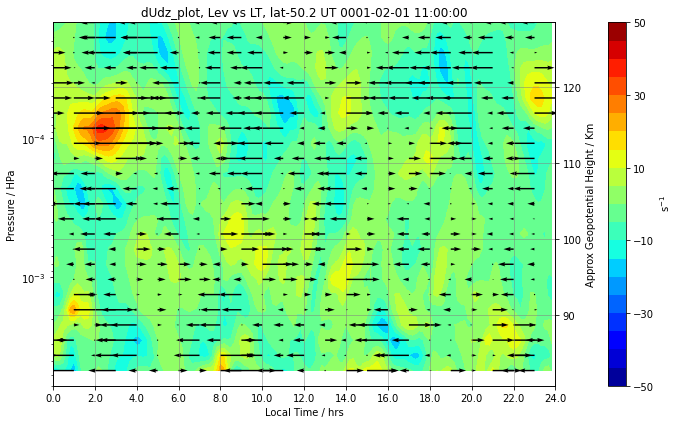

In [55]:
#----------------------------------------------------------------------------------------------------------
#-----------------------------------------  dUdz_plot arrows  -----------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot_idx_start = 0  
time_plot_idx_end = 12

time_plot_ar = np.arange(time_plot_idx_start,time_plot_idx_end)

for itime in time_plot_ar:
    time_plot_idx = time_plot_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------
    time_plot = timee[time_plot_idx]
    times_plot = times[time_plot_idx]
    times_plot_str = str(times_plot)
    #print('Plot time = ' + times_plot1_str)   

    #---------------Set up plot variables----------------------------
    dUdz_plot = dUdz[:,time_plot_idx,:]
    
    #------------------------ SpEs_pd_plot -----------------------------

    ticks = np.linspace(-50, 50, 21)

    #fig, ax = plt.subplots(figsize=(8, 5))
    fig, ax = plt.subplots(figsize=(10, 6))
    C = ax.contourf(timeconv_plot, lev_sl[0:-1], dUdz_plot, 
                     levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    P = ax.quiver(timeconv_plot[::6], lev_sl[0:-1], dUdz_plot[:,::6], 0.,
                     scale=30, scale_units='inches', units='inches', width=0.02)
    
    ax.set_yscale('log')
    ax.set_ylabel('Pressure / HPa')
    ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    ax2 = ax.twinx()
    ax2.set_ylabel('Approx Geopotential Height / Km')
    ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)


    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('dUdz_plot, Lev vs LT, lat' + lat_plot_str + ' UT ' + times_plot_str )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' s$^{-1}$')

    figname='dUdz_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_plot_str + '_arrows.png'
    plt.tight_layout()
    plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/' + 'Winds/'+str(figname)) #



In [32]:
U_wind_sh.shape

(25, 336, 96, 144)

/tmp/ipykernel_3571921/3078558877.py:62: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::6])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_3571921/3078558877.py:62: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::6])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_3571921/3078558877.py:62: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To s

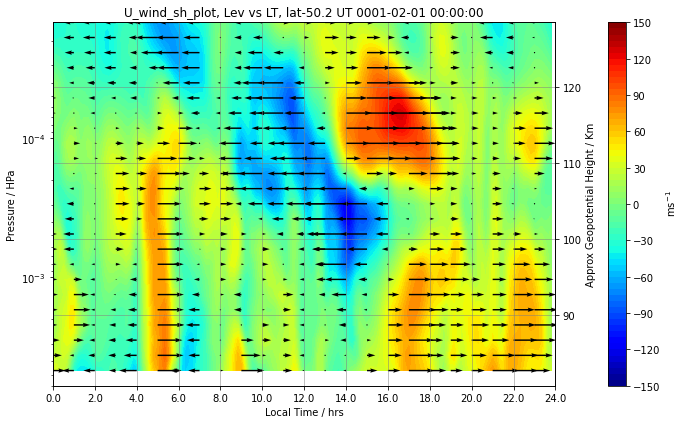

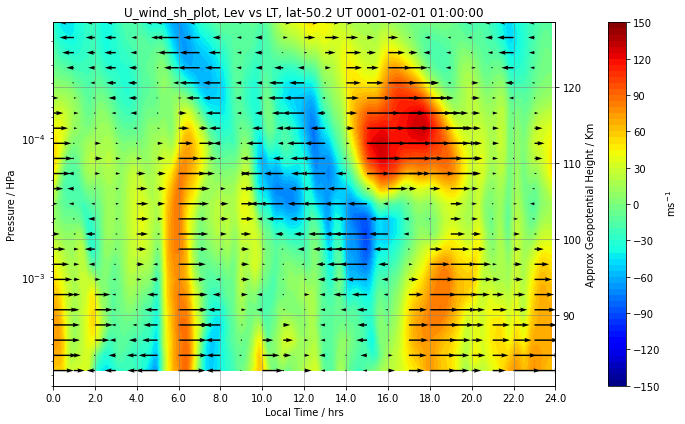

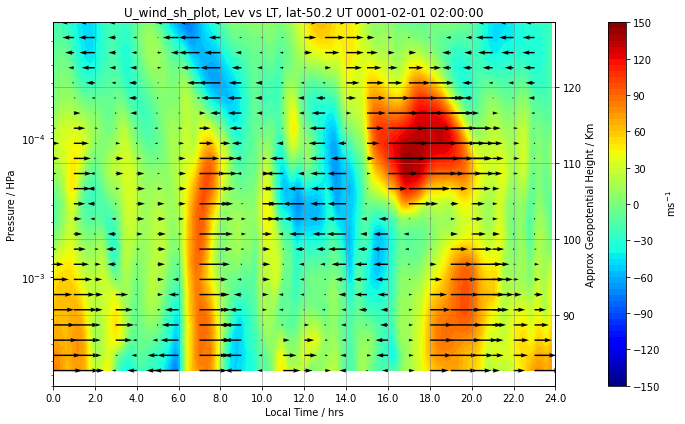

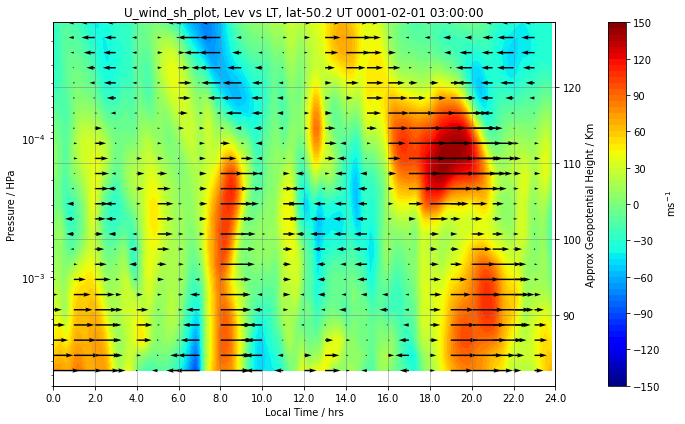

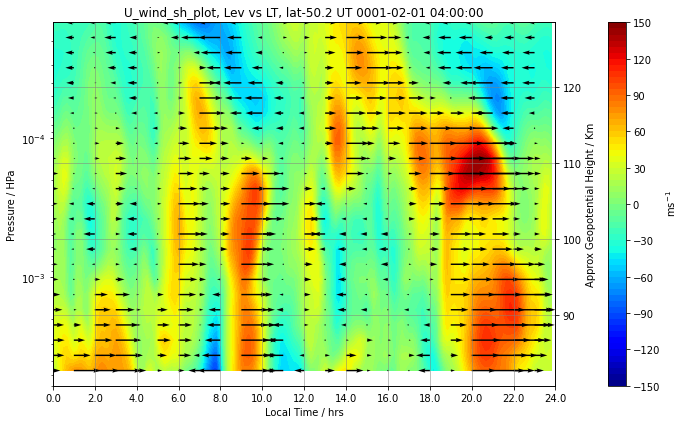

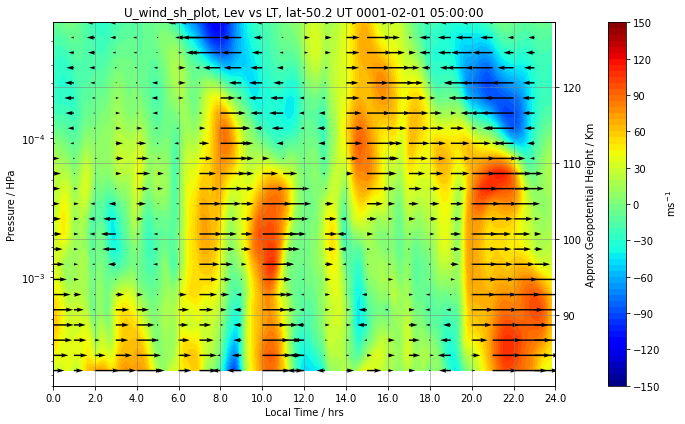

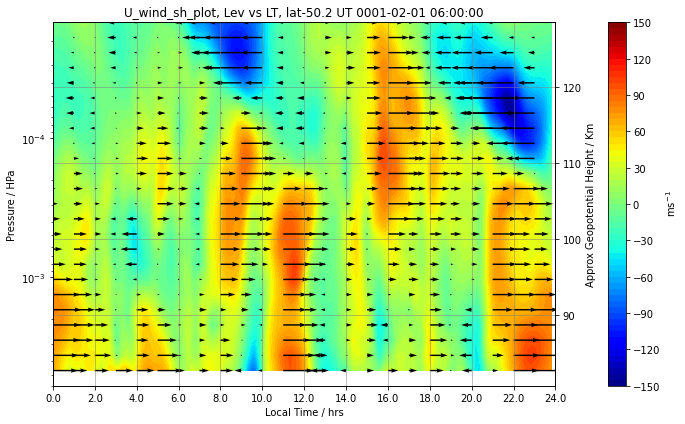

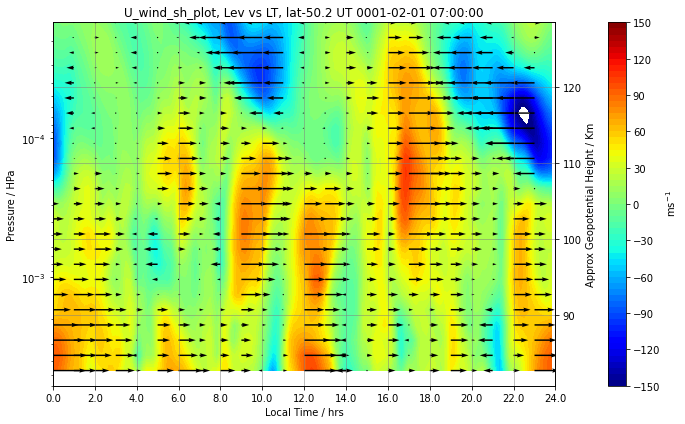

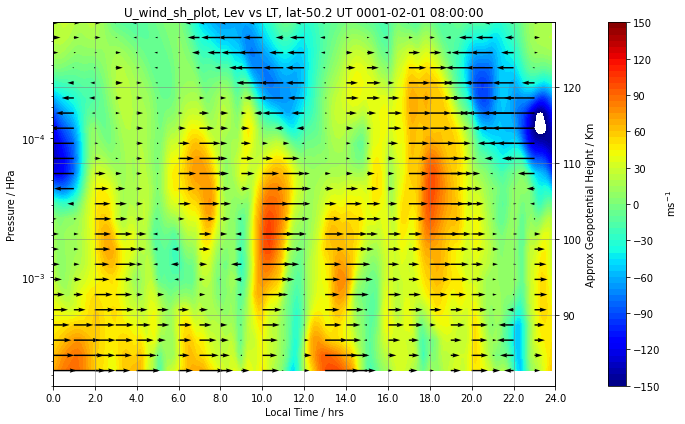

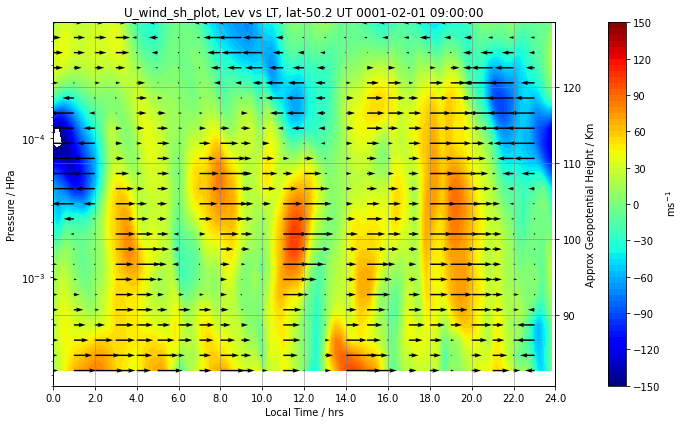

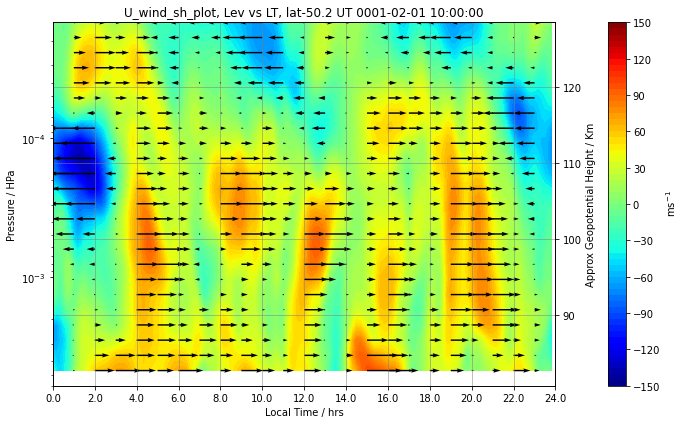

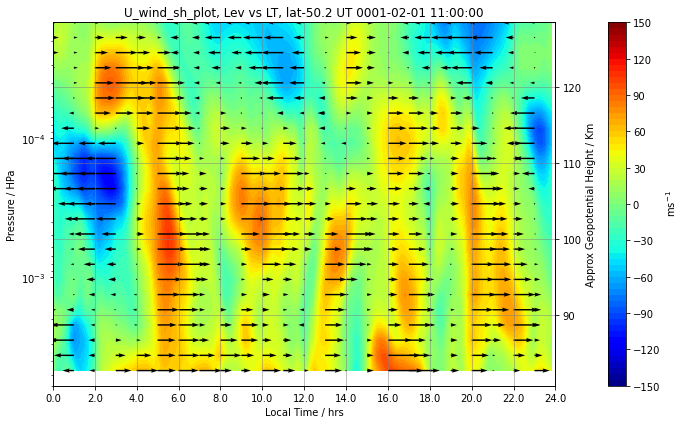

In [54]:
#----------------------------------------------------------------------------------------------------------
#-----------------------------------------  U_wind_sh_plot arrows  -----------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot_idx_start = 0  
time_plot_idx_end = 12

time_plot_ar = np.arange(time_plot_idx_start,time_plot_idx_end)

for itime in time_plot_ar:
    time_plot_idx = time_plot_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------
    time_plot = timee[time_plot_idx]
    times_plot = times[time_plot_idx]
    times_plot_str = str(times_plot)
    #print('Plot time = ' + times_plot1_str)   

    #---------------Set up plot variables----------------------------
    U_wind_sh_plot = U_wind_sh[0:-1,time_plot_idx,lat_plot_idx,:]
    
    #------------------------ SpEs_pd_plot -----------------------------

    ticks = np.linspace(-150, 150, 61)

    #fig, ax = plt.subplots(figsize=(8, 5))
    fig, ax = plt.subplots(figsize=(10, 6))
    C = ax.contourf(timeconv_plot, lev_sl[0:-1], U_wind_sh_plot, 
                     levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    P = ax.quiver(timeconv_plot[::6], lev_sl[0:-1], U_wind_sh_plot[:,::6], 0.,
                     scale=200, scale_units='inches', units='inches', width=0.02)
    
    ax.set_yscale('log')
    ax.set_ylabel('Pressure / HPa')
    ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    ax2 = ax.twinx()
    ax2.set_ylabel('Approx Geopotential Height / Km')
    ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)


    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('U_wind_sh_plot, Lev vs LT, lat' + lat_plot_str + ' UT ' + times_plot_str )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::6])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' ms$^{-1}$')

    figname='U_wind_sh_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_plot_str + '_arrows.png'
    plt.tight_layout()
    plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/' + 'Winds/'+str(figname)) #



/tmp/ipykernel_3574543/2559490116.py:62: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08)#,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,


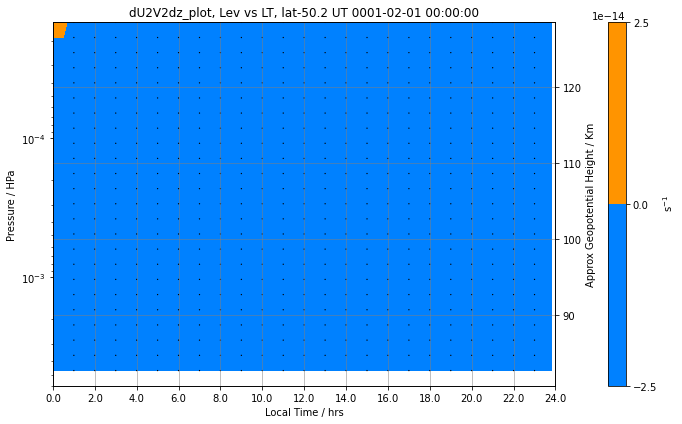

In [28]:
#----------------------------------------------------------------------------------------------------------
#-----------------------------------------  dU2V2dz_plot arrows  -----------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot_idx_start = 0  
time_plot_idx_end = 1

time_plot_ar = np.arange(time_plot_idx_start,time_plot_idx_end)

for itime in time_plot_ar:
    time_plot_idx = time_plot_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------
    time_plot = timee[time_plot_idx]
    times_plot = times[time_plot_idx]
    times_plot_str = str(times_plot)
    #print('Plot time = ' + times_plot1_str)   

    #---------------Set up plot variables----------------------------
    dU2V2dz_plot = dU2V2dz[:,time_plot_idx,:]
    
    #------------------------ SpEs_pd_plot -----------------------------

    #ticks = np.linspace(-200, 200, 21)

    #fig, ax = plt.subplots(figsize=(8, 5))
    fig, ax = plt.subplots(figsize=(10, 6))
    C = ax.contourf(timeconv_plot, lev_sl[0:-1], dU2V2dz_plot, 
                     #levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    P = ax.quiver(timeconv_plot[::6], lev_sl[0:-1], dU2V2dz_plot[:,::6], 0.,
                     scale=30, scale_units='inches', units='inches', width=0.02)
    
    ax.set_yscale('log')
    ax.set_ylabel('Pressure / HPa')
    ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    ax2 = ax.twinx()
    ax2.set_ylabel('Approx Geopotential Height / Km')
    ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)


    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('dU2V2dz_plot, Lev vs LT, lat' + lat_plot_str + ' UT ' + times_plot_str )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.08)#,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' s$^{-1}$')

    figname='dU2V2dz_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_plot_str + '_arrows.png'
    plt.tight_layout()
    #plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/' + 'Winds/'+str(figname)) #

